In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *

In [2]:
experiment = 4
func = 'rosenbrock'
out_best = f'exp{experiment}_{func}.npy'
path = Path(f'../../data/results2/exp{experiment}/{func}')

In [3]:
# funcs
if func=='sphere':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return (indiv.data**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return ((indiv.data +0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return ((indiv.data-b[t]*np.sin(np.pi/2*t))**2).sum()
        def constraint_func(indiv, b, t): return 0
    
elif func=='rastrigin':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return 10*D+((indiv.data**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data+0.1*t)**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return 10*D+(((indiv.data-b[t]*np.sin(np.pi/2*t))**2)-10*np.cos(2*np.pi*indiv.data)).sum()
        def constraint_func(indiv, b, t): return 0

elif func=='rosenbrock':
    if experiment==1 or experiment==2:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        def fitness_func(indiv, b, t): return ((100 * (indiv.data[1:] - indiv.data[:-1]**2)**2) + (1-indiv.data[:-1])**2).sum()
        def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

    elif experiment==3:
        ab=[]
        # experiment 3: dynamic fitness function (linear)
        def fitness_func(indiv, b, t): return (100 * (((indiv.data[1:]+0.1*t) - (indiv.data[:-1]+0.1*t)**2)**2) + (1-indiv.data[:-1]-0.1*t)**2).sum()
        def constraint_func(indiv, b, t): return 0

    else:
        ab=pd.read_csv(path/'dC_01.csv')['b'].values
    # experiment 5: dynamic fitness function (x-sin(pi/2*t))^2 with random changes on peak of sin
        def fitness_func(indiv, b, t): return (((100 * ((indiv.data[1:]-b[t]*np.sin(np.pi/2*t)) - (indiv.data[:-1]-b[t]*np.sin(np.pi/2*t))**2)**2) + (1-indiv.data[:-1]+b[t]*np.sin(np.pi/2*t))**2)).sum()
        def constraint_func(indiv, b, t): return 0

In [4]:
# nn
import torch
import torch.nn.functional as F
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self, d, w, nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel(d=2, w=5, nf=4) 
nn_trainer = partial(NNTrainer, model=model, n=10, sample_size=1, window=5,
                     train_window=None, replace_mechanism=ReplaceMechanism.Worst,
                     bs=4, epochs=10)

In [5]:
D = 2
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
population = Population.new_random(n=30, dimension=D)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=100, frequency=0.1,
#                    callbacks=[Logger, RandomImmigrantsOnChange],
                   callbacks=[Logger, OnChangeRestartPopulation],
#                    callbacks=[Logger],
#                    callbacks=[Logger, nn_trainer], metrics=[],
#                    callbacks=[Logger, Hypermutation],
#                    callbacks=[Logger], evolve_mechanism=EvolveMechanism.CrowdingN,
                   path='test_logger')
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 00:11


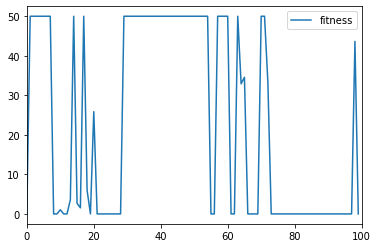

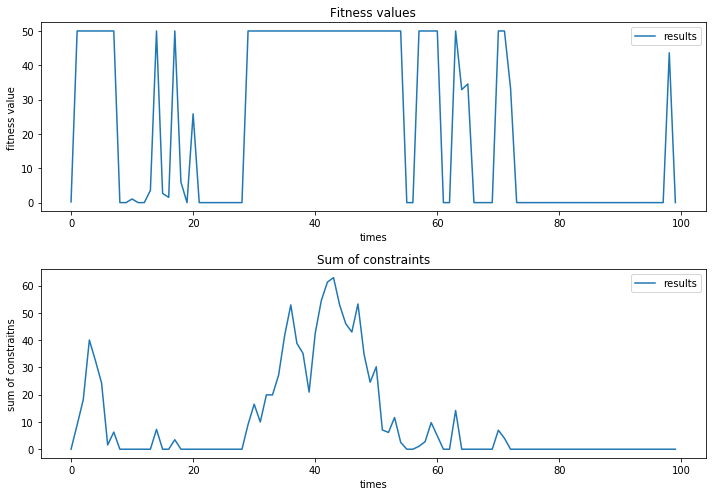

In [6]:
opt.run(100000)
opt.recorder.plot();

In [7]:
opt.logger

Logger(path='test_logger/logger.json')

In [8]:
!cp {opt.logger.path} /home/renato/tmp/ea_data.json